# Mount the drive

In [66]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

# Move to the folder where you've downloaded the file diabetes.csv

In [67]:
# %cd gdrive/MyDrive/MLNDNN/Notebooks/Lecture7/data

In [68]:
# %ls

# **Pima Indians Diabetes  Database**  
* # The datasets consist of $8$ medical predictor (independent) variables and one target (dependent) variable, **Outcome**.
* # Independent variables include the *number of pregnancies* the patient has had, their *BMI*, *insulin level*, *age*, and so on.

In [69]:
# %pip install scikit-learn==1.5.0

In [70]:

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np
from sklearn.linear_model import  LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split,  StratifiedKFold, GridSearchCV



data = pd.read_csv('./mine/data/diabetes.csv')
# print(data.head(5))
data.isnull().sum()


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [71]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [72]:
y = data['Outcome']
print(f"Number of 0:{(y==0).sum()}")
print(f"Number of 1:{(y==1).sum()}")
data = data.drop('Outcome', axis=1)
colnames= data.columns.values.tolist()
colnames

Number of 0:500
Number of 1:268


['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

# **Normalizing data**
* ## For the age we don't apply a standard scaler, does not make sense

In [73]:
sscaler = StandardScaler()
mmscaler = MinMaxScaler()
dbt_tf = ColumnTransformer(
    transformers=[
        ('other', sscaler, colnames[:-1]),
        ('Age', mmscaler, ['Age'])
    ],
    verbose_feature_names_out = False
)
#dbt_tf.fit(data)
#new_data = pd.DataFrame(dbt_tf.transform(data)
#                            ,columns=dbt_tf.get_feature_names_out()
#                            )
#new_data

# **Let's evaluate a Logistic Regression model trained on such data**
* ## Operate a model selection on the $C$ hyperparameter and the type of regularization/penalty
  * ### $C$ regulates how much we want to regularize
    * #### The larger C, less regularization is applied, the model will fit more the training data
  * ### As regularizer we pick $L1$ and $L2$  
* ## We use a grid search
* ## Due to a slight imbalance in data, use the F1 measure to pick the best configuration

In [74]:
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
    'penalty' : ['l1','l2']
}

skf = StratifiedKFold(n_splits=3)

test_f1 = []
test_acc = []

for train_idx, test_idx in skf.split(data, y):
  x_train, y_train = data.iloc[train_idx,:], y[train_idx]
  x_test, y_test = data.iloc[test_idx,:], y[test_idx]
  dbt_tf.fit(x_train)
  x_train=pd.DataFrame(dbt_tf.transform(x_train),
                         columns=dbt_tf.get_feature_names_out()
                          )
  x_test = pd.DataFrame(dbt_tf.transform(x_test),
                          columns=dbt_tf.get_feature_names_out()
                          )
  cls = LogisticRegression(solver='liblinear')
  GS = GridSearchCV(estimator=cls,
                param_grid=param_grid,
                scoring='f1',
                refit=True,
                cv=3,
                verbose = 0)

  sol = GS.fit(x_train, y_train)
  print(f'Best score got by the best estimator: {sol.best_score_}')
  print(f'Configuration for the best estimator/classifier: {sol.best_params_}')

  best_LR = sol.best_estimator_
  pred = best_LR.predict(x_test)
  test_f1.append(f1_score(y_test, pred))
  test_acc.append(accuracy_score(y_test, pred))

print(f"Mean f1 test:{np.mean(test_f1)} +/-:{np.std(test_f1)}")
print(f"Mean Accuracy test:{np.mean(test_acc)} +/-:{np.std(test_acc)}")

Best score got by the best estimator: 0.6565275957477792
Configuration for the best estimator/classifier: {'C': 0.0001, 'penalty': 'l2'}
Best score got by the best estimator: 0.6566685531031881
Configuration for the best estimator/classifier: {'C': 0.001, 'penalty': 'l2'}
Best score got by the best estimator: 0.6331841010187976
Configuration for the best estimator/classifier: {'C': 0.1, 'penalty': 'l2'}
Mean f1 test:0.6359184352403596 +/-:0.018128061310017263
Mean Accuracy test:0.7669270833333334 +/-:0.021236336497786574


# **Let's use an MLP to classify the same data**
*  # We operate a model selection even in this case
* # Keras models can be used in scikit-learn by wrapping them with the ```KerasClassifier``` or ```KerasRegressor``` class from the module ```SciKeras```
 * # [Scikeras documentation](https://www.adriangb.com/scikeras/stable/index.html)
 * # You may need to run the command ```pip install scikeras``` first to install the module

* # It is quite simple: we need to define a method (e.g., ```create_model```) to create our model
 * #  then feed it as argument ```model``` of ```KerasClassifier``` constructor

   # e.g.: ```KerasClassifier(model=create_model)```

In [75]:

from scikeras.wrappers import KerasClassifier


In [76]:
#import tensorflow as tf
#import keras as K
#print( K.__version__ )
#print( tf.__version__)
#print( tf.keras.__version__)

# **Let's define our create_model() method**

 * # Argument which do not have a default value must be specified in the next ```KerasClassifier()``` call
  * # as individual arguments
  * # and (optionally) in the grid for grid search
  * # We'll create a MLP with one output unit with sigmoidal activation, for example
    * ## The we threshold the output
  * ## `kernel_regularizer` is the argument of a layer to specify a regularization term for the weights in that layer  


In [77]:
import tensorflow as tf
np.random.seed(123)  # for reproducibility
tf.random.set_seed(123)
input_shape= data.shape[1]
print(f"input_shape:{input_shape}, num_classes:{len(np.unique(y))}")
from tensorflow.keras.models import Sequential
# dense is a fully connected layer
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
# function which defines the model to be used
#  by scikit-learn API
def create_model(nhid1, nhid2,
                 learning_rate= 10**-1,
                 loss='BinaryCrossentropy',
                 hid_act='relu',
                 out_act='sigmoid',
                 dropout_rate=0,
                 weight_reg=None):
  # learning_rate: the learning rate to be used by the optimizer
  # nhid1: number of hidden neurons in the first hidden layer
  # nhid2: number of hidden neurons in the first hidden layer
  # loss: loss function to be used
  # hid_act: activation function for hidden layers
  # out_act: activation function for output layer
  # dropout_rate: the rate of dropout to be used

  model = Sequential()
  model.add(Dense(nhid1,
                  input_shape=(input_shape,),
                  activation=hid_act,
                  kernel_regularizer=weight_reg))
  # set dropout regularization
  model.add(Dropout(dropout_rate))
  model.add(Dense(nhid2,
                  activation=hid_act,
                  kernel_regularizer=weight_reg))
  model.add(Dropout(dropout_rate))
  model.add(Dense(1, activation=out_act))
  model.compile(loss=loss,
        optimizer=SGD(learning_rate=learning_rate),
        metrics=['accuracy'])

  return model



input_shape:8, num_classes:2


# **Instantiating the model**
* ## Since we use a wrapper for `scikit-learn`, we can then train the model using the `fit` method, and query it by invoking `predict`!

In [78]:
# Wrapper class for scikit-learn API
model = KerasClassifier(model=create_model,
                        nhid1 = 50,# these are arguments to
                        # create_model
                        nhid2=50,
                        epochs=20)
x_train, x_test, y_train, y_test = train_test_split(data,y,test_size=0.1,
                                                    shuffle=True, stratify=y)
dbt_tf.fit(x_train)
x_train=pd.DataFrame(dbt_tf.transform(x_train)
                          ,columns=dbt_tf.get_feature_names_out()
                          )
x_test = pd.DataFrame(dbt_tf.transform(x_test)
                          ,columns=dbt_tf.get_feature_names_out()
                          )
# These are the scikit-learn fit and predict!
#  learning the model on all data
model.fit(x_train, y_train)
pred = model.predict(x_test)
threshold = 0.5
predicted_labels = (pred >= threshold).astype(int)
# training perf
print(f"Training accuracy: {accuracy_score(y_test, pred)}")
print(f"Training F: {f1_score(y_test, pred)}")

Epoch 1/20


/Users/theo/Desktop/theo/Uni/Second Year/Second Semester/NN & DL/Labs/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5919 - loss: 0.6688  
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7349 - loss: 0.5736 
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - accuracy: 0.7532 - loss: 0.5296
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - accuracy: 0.7514 - loss: 0.5091
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - accuracy: 0.7535 - loss: 0.5004
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - accuracy: 0.7534 - loss: 0.4954
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - accuracy: 0.7576 - loss: 0.4914
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - accuracy: 0.7595 - loss: 0.4880
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.7628 - loss: 0.4846
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - accuracy: 0.7658 - loss: 0.4813
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - accuracy: 0.7705 - loss: 0.4782
Epoch 12/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy

# **The optimizer**
* ## So far we have used the Stochastic Gradient Descent. Here the [docs](https://keras.io/api/optimizers/sgd/)
* # In the next lecture we will discuss about the momentum and introduce the other optimizers RMSprop and Adam.
* # For now let's just use them!!
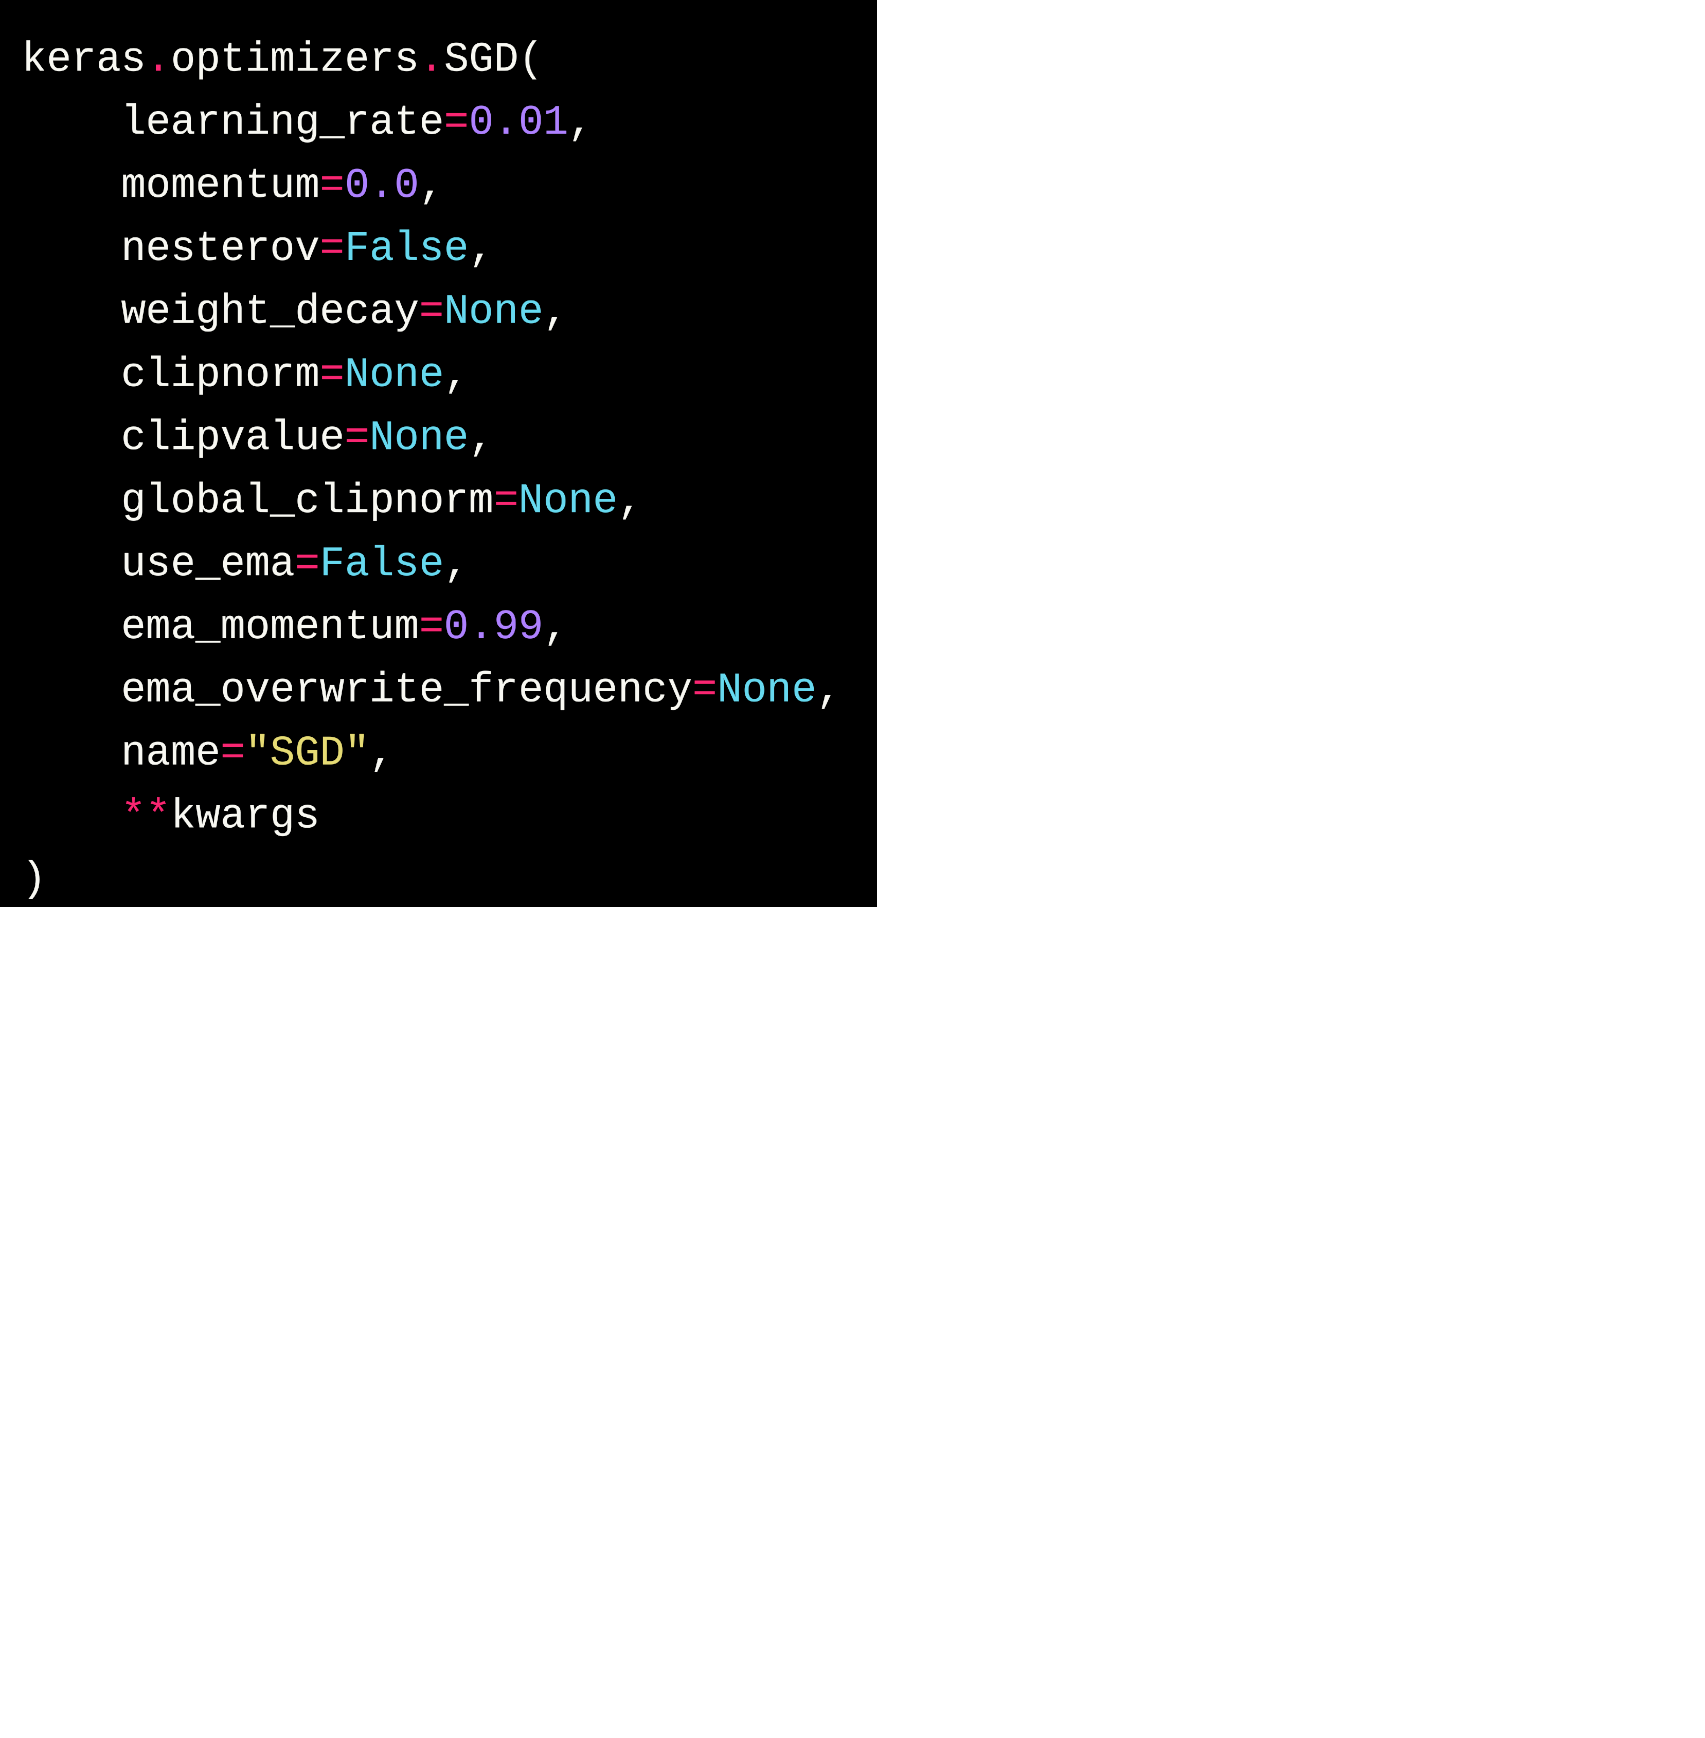

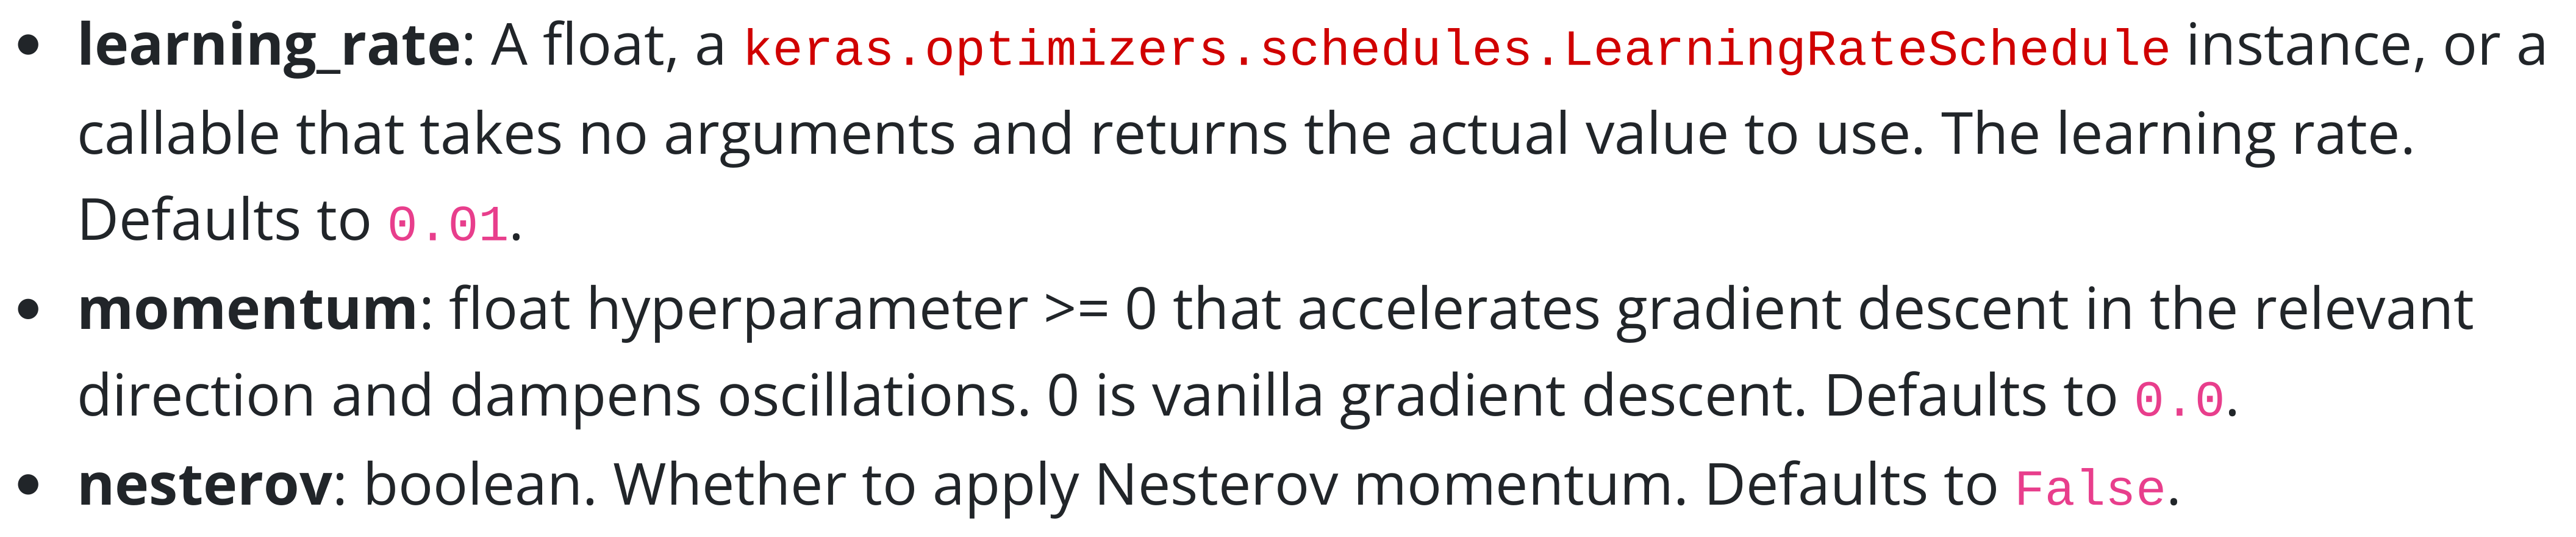

* ## **Link to RMSprop** [docs](https://keras.io/api/optimizers/rmsprop/)
* ## **Link to Adam** [docs](https://keras.io/api/optimizers/adam/)

# ***Model selection*** (hyperameter optimization) using scikit-learn

* ## We can leverage for instance the ```GridSearchCV```  method!

* ## We want to tune the number of hidden neurons in the hidden layers

 * ### However we need to specify their value when calling the KerasClassifier constructor, since they dont have a default value
* ## The *learning rate*
* ## The *weight regularizer* (we'll back to this as well)
* ## The *batch_size*
* ## The *Activation function*
* ## The *Dropout level* (we will talk about it in next lecture)  
* # Pay attention to the dictionary definition
 * ### To tune model arguments, the dictionary name of that argument must start with **"model__"**
 * ### The arguments to Keras `fit` method, like batch size and weight regularization, do not need that prefix in the dictionary name

In [79]:
model = KerasClassifier(model=create_model,
                        nhid1 = 100,# these are arguments to create_model
                        nhid2=50,
                        epochs=20)
## define the grid search parameters for the number of
#   neurons in the hidden layers
nhid1 = [50]
nhid2 = [30, 15]
lr = [7.5*10**-2, 10**-1]

weight_reg = [None, 'l2']
#hid_act = ['relu', 'sigmoid']
hid_act = ['relu'] # not tuned to reduce the number of combinations
#batch_size = [8, 16]
batch_size = [32] # not tuned to reduce the number of combinations
dropout = [0]
#loss = ['BinaryCrossentropy', 'mse']
loss = ['BinaryCrossentropy'] # not tuned to reduce the number of combinations
## dictionary names must start with model__,
#   if it is an argument of the model,
##   followed by the model argument name
param_grid = dict(model__nhid1= nhid1,
                  model__nhid2= nhid2,
                  model__learning_rate= lr,
                  model__weight_reg= weight_reg,
                  model__hid_act= hid_act,
                  batch_size=batch_size,
                  model__dropout_rate= dropout,
                  model__loss= loss
                  )


# **Model selection in holdout setting**

In [80]:
x_train, x_test, y_train, y_test = train_test_split(data,y,test_size=0.1,
                                                    shuffle=True, stratify=y)
x_train=pd.DataFrame(dbt_tf.transform(x_train)
                          ,columns=dbt_tf.get_feature_names_out()
                          )
dbt_tf.fit(x_train)
x_test = pd.DataFrame(dbt_tf.transform(x_test)
                          ,columns=dbt_tf.get_feature_names_out()
                          )
GS = GridSearchCV(estimator=model, param_grid=param_grid,
                  n_jobs=1,
                  scoring='f1',
                  cv=3,
                  verbose=1)
grid_result = GS.fit(x_train, y_train)
# best result
print("Best: %f using %s" % (grid_result.best_score_,
                             grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
# printing results for all combinations
for mean, param in zip(means, params):
    print(f"{mean} \t with: {param}")




Fitting 3 folds for each of 8 candidates, totalling 24 fits
Epoch 1/20


/Users/theo/Desktop/theo/Uni/Second Year/Second Semester/NN & DL/Labs/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4738 - loss: 0.7052  
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7275 - loss: 0.6184 
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7511 - loss: 0.5672 
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7718 - loss: 0.5330 
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7783 - loss: 0.5116 
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7764 - loss: 0.4986 
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7783 - loss: 0.4904 
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7750 - loss: 0.4853 
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7732 - loss: 0.4818 
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7722 - loss: 0.4791 
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7679 - loss: 0.4766 
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7687 - l

/Users/theo/Desktop/theo/Uni/Second Year/Second Semester/NN & DL/Labs/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3988 - loss: 0.7265  
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7175 - loss: 0.6105 
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7527 - loss: 0.5535 
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7846 - loss: 0.5136 
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7887 - loss: 0.4845 
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8088 - loss: 0.4638 
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8073 - loss: 0.4497 
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8001 - loss: 0.4397 
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8011 - loss: 0.4329 
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8030 - loss: 0.4282 
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8041 - loss: 0.4249 
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8041 - l

/Users/theo/Desktop/theo/Uni/Second Year/Second Semester/NN & DL/Labs/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6339 - loss: 0.6614  
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7200 - loss: 0.5885 
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7521 - loss: 0.5453 
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7645 - loss: 0.5194 
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7737 - loss: 0.5037 
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7733 - loss: 0.4936 
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7690 - loss: 0.4866 
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7795 - loss: 0.4811 
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7834 - loss: 0.4762 
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7851 - loss: 0.4723 
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7801 - loss: 0.4686 
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7801 - l

/Users/theo/Desktop/theo/Uni/Second Year/Second Semester/NN & DL/Labs/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6193 - loss: 1.1873  
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6831 - loss: 1.1041 
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7104 - loss: 1.0404 
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7455 - loss: 0.9891 
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7603 - loss: 0.9485 
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7723 - loss: 0.9165 
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7740 - loss: 0.8902 
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7800 - loss: 0.8683 
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7807 - loss: 0.8488 
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7805 - loss: 0.8312 
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7882 - loss: 0.8148 
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7854 - l

/Users/theo/Desktop/theo/Uni/Second Year/Second Semester/NN & DL/Labs/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4945 - loss: 1.2307  
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7217 - loss: 1.0816 
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7612 - loss: 1.0166 
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7796 - loss: 0.9682 
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7829 - loss: 0.9282 
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7868 - loss: 0.8939 
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7917 - loss: 0.8644 
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7852 - loss: 0.8391 
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7841 - loss: 0.8170 
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7975 - loss: 0.7972 
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7949 - loss: 0.7791 
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7949 - l

/Users/theo/Desktop/theo/Uni/Second Year/Second Semester/NN & DL/Labs/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5849 - loss: 1.1794  
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7225 - loss: 1.0795 
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7602 - loss: 1.0154 
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7731 - loss: 0.9684 
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7880 - loss: 0.9317 
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7864 - loss: 0.9020 
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7902 - loss: 0.8771 
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7880 - loss: 0.8557 
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7906 - loss: 0.8367 
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7973 - loss: 0.8193 
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7962 - loss: 0.8031 
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7931 - l

/Users/theo/Desktop/theo/Uni/Second Year/Second Semester/NN & DL/Labs/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6428 - loss: 0.6897  
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6904 - loss: 0.6008 
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7483 - loss: 0.5541 
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7694 - loss: 0.5257 
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7767 - loss: 0.5074 
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7801 - loss: 0.4949 
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7785 - loss: 0.4861 
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7781 - loss: 0.4798 
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7855 - loss: 0.4741 
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7847 - loss: 0.4696 
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7831 - loss: 0.4656 
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7831 - l

/Users/theo/Desktop/theo/Uni/Second Year/Second Semester/NN & DL/Labs/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6734 - loss: 0.6460  
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7538 - loss: 0.5860 
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7781 - loss: 0.5415 
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7735 - loss: 0.5076 
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7816 - loss: 0.4828 
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7839 - loss: 0.4656 
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7915 - loss: 0.4544 
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7995 - loss: 0.4472 
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7896 - loss: 0.4422 
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7900 - loss: 0.4387 
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7915 - loss: 0.4360 
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7915 - l

/Users/theo/Desktop/theo/Uni/Second Year/Second Semester/NN & DL/Labs/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5541 - loss: 0.6927  
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7067 - loss: 0.6152 
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7557 - loss: 0.5706 
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7647 - loss: 0.5375 
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7866 - loss: 0.5128 
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7949 - loss: 0.4956 
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7981 - loss: 0.4843 
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7896 - loss: 0.4766 
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7895 - loss: 0.4711 
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7778 - loss: 0.4667 
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7785 - loss: 0.4629 
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7799 - l

/Users/theo/Desktop/theo/Uni/Second Year/Second Semester/NN & DL/Labs/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6108 - loss: 0.9966  
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6864 - loss: 0.9228 
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7311 - loss: 0.8762 
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7515 - loss: 0.8409 
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7668 - loss: 0.8145 
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7637 - loss: 0.7931 
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7727 - loss: 0.7751 
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7735 - loss: 0.7584 
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7719 - loss: 0.7437 
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7719 - loss: 0.7308 
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7719 - loss: 0.7184 
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7719 - l

/Users/theo/Desktop/theo/Uni/Second Year/Second Semester/NN & DL/Labs/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5200 - loss: 1.0660  
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6646 - loss: 0.9797 
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7112 - loss: 0.9190 
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7635 - loss: 0.8628 
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7875 - loss: 0.8162 
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7958 - loss: 0.7802 
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8088 - loss: 0.7527 
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8068 - loss: 0.7308 
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8007 - loss: 0.7125 
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7971 - loss: 0.6969 
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7955 - loss: 0.6833 
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7955 - l

/Users/theo/Desktop/theo/Uni/Second Year/Second Semester/NN & DL/Labs/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6070 - loss: 1.0741  
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7121 - loss: 0.9760 
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7353 - loss: 0.9228 
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7539 - loss: 0.8822 
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7634 - loss: 0.8514 
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7745 - loss: 0.8271 
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7750 - loss: 0.8071 
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7750 - loss: 0.7897 
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7745 - loss: 0.7742 
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7795 - loss: 0.7600 
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7766 - loss: 0.7468 
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7803 - l

/Users/theo/Desktop/theo/Uni/Second Year/Second Semester/NN & DL/Labs/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6162 - loss: 0.6864  
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6522 - loss: 0.6123 
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7409 - loss: 0.5649 
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7662 - loss: 0.5322 
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7793 - loss: 0.5093 
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7880 - loss: 0.4951 
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7866 - loss: 0.4856 
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7815 - loss: 0.4787 
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7824 - loss: 0.4728 
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7824 - loss: 0.4678 
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7824 - loss: 0.4636 
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7802 - l

/Users/theo/Desktop/theo/Uni/Second Year/Second Semester/NN & DL/Labs/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4897 - loss: 0.6997  
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7178 - loss: 0.6105 
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7436 - loss: 0.5575 
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7705 - loss: 0.5148 
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7670 - loss: 0.4839 
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8023 - loss: 0.4621 
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7962 - loss: 0.4479 
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7996 - loss: 0.4385 
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8020 - loss: 0.4327 
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8006 - loss: 0.4290 
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7939 - loss: 0.4259 
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7919 - l

/Users/theo/Desktop/theo/Uni/Second Year/Second Semester/NN & DL/Labs/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5759 - loss: 0.6756  
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7794 - loss: 0.5580 
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7931 - loss: 0.5118 
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7903 - loss: 0.4865 
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7969 - loss: 0.4718 
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8008 - loss: 0.4630 
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8055 - loss: 0.4572 
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8033 - loss: 0.4532 
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8046 - loss: 0.4501 
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8002 - loss: 0.4475 
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8013 - loss: 0.4453 
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7998 - l

/Users/theo/Desktop/theo/Uni/Second Year/Second Semester/NN & DL/Labs/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6330 - loss: 1.1648  
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6674 - loss: 1.0598 
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7454 - loss: 0.9938 
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7786 - loss: 0.9455 
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7712 - loss: 0.9086 
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7615 - loss: 0.8782 
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7619 - loss: 0.8521 
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7654 - loss: 0.8287 
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7647 - loss: 0.8070 
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7682 - loss: 0.7867 
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7682 - loss: 0.7680 
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7698 - l

/Users/theo/Desktop/theo/Uni/Second Year/Second Semester/NN & DL/Labs/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6553 - loss: 1.1422  
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7304 - loss: 1.0401 
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7882 - loss: 0.9677 
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8110 - loss: 0.9131 
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7923 - loss: 0.8717 
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7981 - loss: 0.8392 
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7967 - loss: 0.8116 
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7889 - loss: 0.7873 
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7882 - loss: 0.7653 
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7900 - loss: 0.7453 
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7930 - loss: 0.7269 
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7930 - l

/Users/theo/Desktop/theo/Uni/Second Year/Second Semester/NN & DL/Labs/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4291 - loss: 1.2045  
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6884 - loss: 1.0928 
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7114 - loss: 1.0265 
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7609 - loss: 0.9722 
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7791 - loss: 0.9267 
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7773 - loss: 0.8896 
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7816 - loss: 0.8584 
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7839 - loss: 0.8318 
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7834 - loss: 0.8088 
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7834 - loss: 0.7882 
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7824 - loss: 0.7693 
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7845 - l

/Users/theo/Desktop/theo/Uni/Second Year/Second Semester/NN & DL/Labs/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5907 - loss: 0.6613  
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7380 - loss: 0.5812 
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7529 - loss: 0.5433 
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7670 - loss: 0.5189 
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7771 - loss: 0.5058 
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7767 - loss: 0.4973 
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7751 - loss: 0.4906 
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7765 - loss: 0.4847 
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7802 - loss: 0.4795 
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7780 - loss: 0.4748 
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7801 - loss: 0.4705 
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7878 - l

/Users/theo/Desktop/theo/Uni/Second Year/Second Semester/NN & DL/Labs/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6139 - loss: 0.6636  
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7429 - loss: 0.5499 
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7633 - loss: 0.4957 
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7770 - loss: 0.4695 
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7927 - loss: 0.4554 
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7997 - loss: 0.4466 
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7997 - loss: 0.4406 
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8074 - loss: 0.4361 
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8084 - loss: 0.4324 
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8084 - loss: 0.4295 
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8084 - loss: 0.4268 
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8074 - l

/Users/theo/Desktop/theo/Uni/Second Year/Second Semester/NN & DL/Labs/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6580 - loss: 0.6672  
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7081 - loss: 0.5706 
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7457 - loss: 0.5268 
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7663 - loss: 0.5036 
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7763 - loss: 0.4909 
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7820 - loss: 0.4833 
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7799 - loss: 0.4783 
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7833 - loss: 0.4744 
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7833 - loss: 0.4709 
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7872 - loss: 0.4682 
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7944 - loss: 0.4651 
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7944 - l

/Users/theo/Desktop/theo/Uni/Second Year/Second Semester/NN & DL/Labs/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6183 - loss: 1.0614  
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6884 - loss: 0.9635 
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7310 - loss: 0.8972 
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7492 - loss: 0.8498 
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7725 - loss: 0.8151 
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7752 - loss: 0.7887 
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7745 - loss: 0.7672 
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7756 - loss: 0.7487 
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7738 - loss: 0.7318 
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7738 - loss: 0.7164 
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7774 - loss: 0.7020 
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7795 - l

/Users/theo/Desktop/theo/Uni/Second Year/Second Semester/NN & DL/Labs/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6777 - loss: 0.9961  
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7879 - loss: 0.8828 
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7894 - loss: 0.8189 
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7904 - loss: 0.7780 
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7967 - loss: 0.7490 
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8043 - loss: 0.7256 
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8045 - loss: 0.7060 
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8002 - loss: 0.6888 
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8039 - loss: 0.6736 
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8023 - loss: 0.6595 
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8038 - loss: 0.6463 
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8038 - l

/Users/theo/Desktop/theo/Uni/Second Year/Second Semester/NN & DL/Labs/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5697 - loss: 1.0314  
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7295 - loss: 0.9475 
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7487 - loss: 0.8883 
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7798 - loss: 0.8427 
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7798 - loss: 0.8060 
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7947 - loss: 0.7780 
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7959 - loss: 0.7548 
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7963 - loss: 0.7352 
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7966 - loss: 0.7177 
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7936 - loss: 0.7021 
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7936 - loss: 0.6880 
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7943 - l

/Users/theo/Desktop/theo/Uni/Second Year/Second Semester/NN & DL/Labs/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6816 - loss: 1.1535  
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7545 - loss: 1.0368 
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7691 - loss: 0.9613 
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7683 - loss: 0.9096 
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7893 - loss: 0.8713 
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7822 - loss: 0.8410 
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7753 - loss: 0.8152 
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7650 - loss: 0.7924 
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7688 - loss: 0.7712 
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7690 - loss: 0.7517 
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7710 - loss: 0.7336 
Epoch 12/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7720 - l

In [81]:
print("Holdout test performance")
model = GS.best_estimator_
y_test_predicted = model.predict(x_test)
threshold = 0.5
y_test_predicted = (y_test_predicted >= threshold).astype(int)
print(f"test  F1:{f1_score(y_test, y_test_predicted)}")
print(f"test  Accuracy:{accuracy_score(y_test, y_test_predicted)}")


Holdout test performance
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
test  F1:0.5192307692307693
test  Accuracy:0.35064935064935066


# **TASK**:
* # Work in group of 4/5 students
* # Try to optimize a model for the MNIST data (see previous laboratory), by trying even other optimizers
* # You might use subsequent grids to select the different hyperparapers while reducing the number of combinations:
  * ## e.g., in a first run fix some hyperparameters $A$, and just tune the remaining ones $B$
  * ## The pick the best configuration for hyperparameters in $A$, and tune those in $B$

# **Store**:
* ## The *best accuracy value* on test data
* ##  The grid of values tried and the best configuration found (corresponding to the best accuracy value)

# **Attention!**: Job time is limited in Colab. Your execution migh be stopped if it last more than 12 hours (depends on resource usage).
   * ###  Define the grid accordingly    